In [53]:
import numpy as np
dir_path = 'results/no.109_Drd1-Cre.xlsx_20250307_050035/'


fold = 2

prediction = np.load(f'{dir_path}predictions_fold_{fold}.npy')[:, 0]
ground_truth = np.load(f'{dir_path}ground_truth_fold_{fold}.npy')[:, 0]
n_samples = len(ground_truth)
l, r = int(n_samples * fold / 5), int(n_samples * (fold+1) / 5)
prediction = prediction[l:r]
ground_truth = ground_truth[l:r]

n_samples = len(ground_truth)



In [54]:
def calculate_peak_metrics(peaks1, peaks2, tolerance=10):
    TP = 0
    FP = 0
    FN = 0
    
    # 複製一份 peaks2 用來追蹤已匹配的點
    matched_peaks2 = set()
    
    # 對於 peaks1 中的每個點，尋找最近的 peaks2 點
    for p1 in peaks1:
        matched = False
        for i, p2 in enumerate(peaks2):
            if i not in matched_peaks2 and abs(p1 - p2) <= tolerance:
                TP += 1
                matched_peaks2.add(i)
                matched = True
                break
        if not matched:
            FN += 1
    
    # 計算未匹配的 peaks2 點作為 FP
    FP = len(peaks2) - len(matched_peaks2)
    
    # 計算指標
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 使用範例
peaks1 = np.array([84, 309, 381, 494])
peaks2 = np.array([87, 310, 383, 496])

metrics = calculate_peak_metrics(peaks1, peaks2, tolerance=10)

print(f"True Positives: {metrics['TP']}")
print(f"False Positives: {metrics['FP']}")
print(f"False Negatives: {metrics['FN']}")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1 Score: {metrics['f1']:.3f}")


import numpy as np

def compute_ap(P, R):
    """
    計算 Average Precision (AP)
    
    假設 P 與 R 為同長度的 numpy 陣列，其中：
    - P: precision 值
    - R: recall 值，且必須是遞增的
    AP 定義為：AP = sum((R[i] - R[i-1]) * P[i])
    
    若 R array 第一個值不為 0，則會在開頭補 0。
    """
    # 如果 R 的起始值不是 0，則補上 (P[0], 0)
    if R[0] != 0:
        R = np.concatenate(([0], R))
        P = np.concatenate(([P[0]], P))
        
    # 計算 recall 差分
    dR = np.diff(R)
    # AP 為 recall 差分乘上對應 precision 的和
    ap = np.sum(dR * P[1:])  # P[1:] 對應每個 recall 區間的 precision
    return ap

# 範例用法：
# 假設你有以下的 precision 與 recall arrays
P = np.array([1.0, 0.8, 0.6, 0.5])
R = np.array([0.2, 0.5, 0.7, 1.0])

ap_value = compute_ap(P, R)
print("Average Precision:", ap_value)


True Positives: 4
False Positives: 0
False Negatives: 0
Precision: 1.000
Recall: 1.000
F1 Score: 1.000
Average Precision: 0.71


In [55]:
from scipy.signal import find_peaks

ground_truth_peaks = find_peaks(ground_truth, distance = 10)[0]
print(ground_truth_peaks)

[ 37 125 162 208 310 358 477]


In [56]:
Precision_list = []
Recall_list = []

for th in np.arange(0, 1, 0.05):
    peaks_pred = find_peaks(prediction, distance = 10, height=(1-th))[0]
    if len(peaks_pred) == 0:
        continue
    metrics = calculate_peak_metrics(ground_truth_peaks, peaks_pred, tolerance=10)
    Recall = metrics['recall']
    Precision = metrics['precision']
    Precision_list.append(Precision)
    Recall_list.append(Recall)

In [57]:
import matplotlib.pyplot as plt

def plot_precision_recall(recall_list, precision_list):
    """
    根據給定的 recall_list 與 precision_list 畫出 Precision-Recall 曲線
    """
    plt.figure(figsize=(8, 6))
    plt.plot(recall_list, precision_list, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    ap_value = compute_ap(Precision_list, Recall_list)
    plt.title(f'Precision-Recall Curve, AP: {ap_value:.4f}')
    plt.grid(True)
    plt.show()

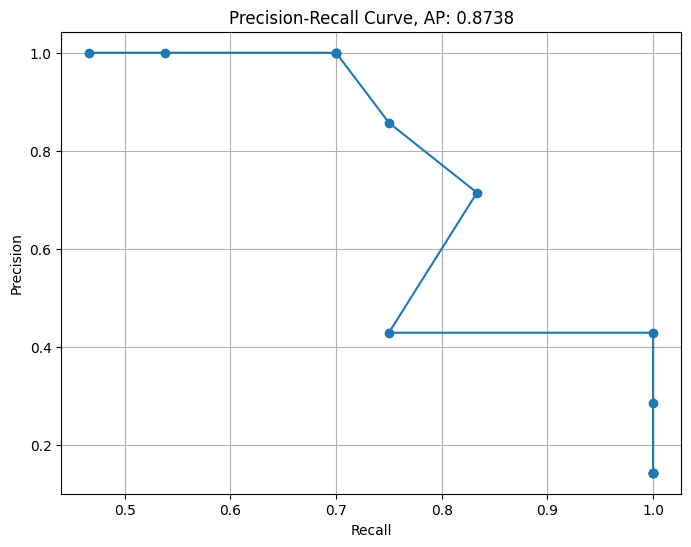

In [58]:
plot_precision_recall(Precision_list, Recall_list)